In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import matplotlib.image as img
import keras
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.applications.resnet_v2 import ResNet101V2
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg16 import VGG16
from keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from IPython.display import clear_output

import warnings
warnings.filterwarnings('ignore')

In [2]:
train_dir = 'c:/workspace/Data/face_mask/Train'
test_dir = 'c:/workspace/Data/face_mask/Test'
val_dir = 'c:/workspace/Data/face_mask/Validation'

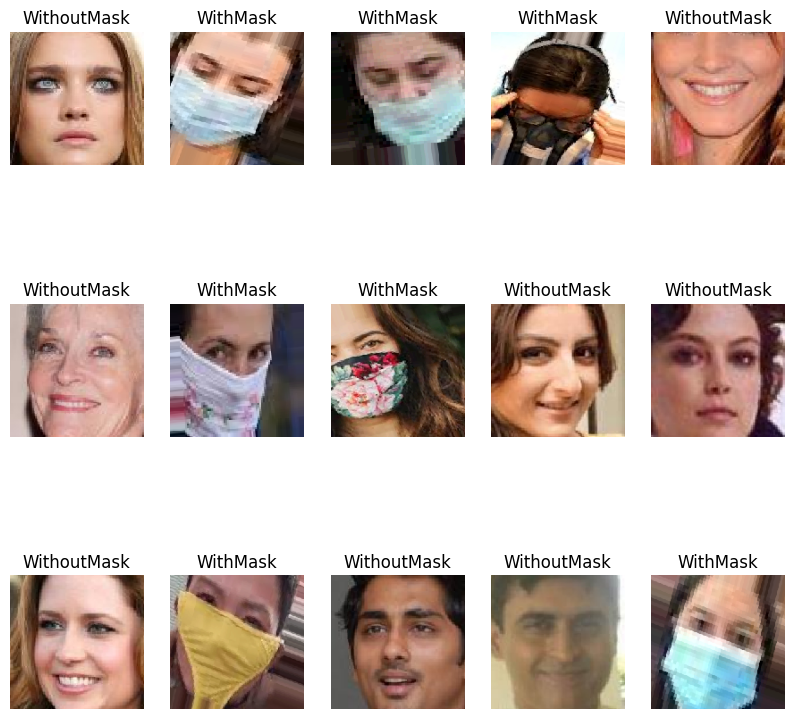

In [3]:
data_train = image_dataset_from_directory(train_dir, labels='inferred',
                                          label_mode='binary', interpolation='nearest',
                                          image_size=[150, 150], batch_size=64, shuffle=True)
classes_train = data_train.class_names
plt.figure(figsize=(10,10))
for img, label in data_train.skip(50).take(1):
    for i in range(15):
        ax = plt.subplot(3,5,i+1)
        plt.imshow(img[i].numpy().astype('uint8'))
        plt.title(classes_train[int(label[i])])
        plt.axis('off')
clear_output()

In [43]:
classes = next(os.walk(train_dir))[1]
print(classes)

['WithMask', 'WithoutMask']


In [4]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=10,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   zoom_range=0.25,
                                   horizontal_flip=True,
                                   samplewise_center=True,     # 평균을 0으로
                                   samplewise_std_normalization=True,   # 표준편차 1로
                                   fill_mode='nearest')
test_datagen = ImageDataGenerator(rescale=1./255)

In [5]:
# 1. InceptionV3 model

IMG_SIZE = (256, 256)                    # Image size is (256, 256) for Inception
train_dataset = train_datagen.flow_from_directory(train_dir, target_size=(IMG_SIZE),
                                         color_mode="rgb",
                                         batch_size=1,         # 메모리 충분하면 늘려서 사용
                                         shuffle=True,
                                         class_mode="categorical")
test_dataset = test_datagen.flow_from_directory(test_dir, target_size=(IMG_SIZE),
                                         color_mode="rgb",
                                         batch_size=1,
                                         shuffle=True,
                                         class_mode="categorical")
validation_dataset = train_datagen.flow_from_directory(val_dir, target_size=(IMG_SIZE),
                                         color_mode="rgb",
                                         batch_size=1,
                                         shuffle=True,
                                         class_mode="categorical")



Found 10000 images belonging to 2 classes.
Found 992 images belonging to 2 classes.
Found 800 images belonging to 2 classes.


In [6]:
# 미니배치 계산
import numpy as np
batch_size=1
n_img = train_dataset.n    # 샘플수
steps = n_img // batch_size
x_tr, y_tr = [], []
for i in range(steps):
    a, b = train_dataset.next()   # 제너레이터에서 배치사이즈만큼 이미지 가져오기
    x_tr.extend(a)
    y_tr.extend(b)
    if i > 200:
        break
x_tr = np.asarray(x_tr)
y_tr = np.asarray(y_tr)
x_tr.shape, y_tr.shape



((202, 256, 256, 3), (202, 2))

In [7]:
import numpy as np
batch_size=1
n_img = validation_dataset.n
steps = n_img // batch_size
x_ts, y_ts = [], []
for i in range(steps):
    a, b = validation_dataset.next()
    x_ts.extend(a)
    y_ts.extend(b)
    if i > 100:
        break
x_ts = np.asarray(x_ts)
y_ts = np.asarray(y_ts)
x_ts.shape, y_ts.shape



((102, 256, 256, 3), (102, 2))

In [8]:
inceptionV3 = InceptionV3(weights='imagenet',include_top=False,input_shape=(256,256,3))  # 인셉션 모델 가져오기, 출력레이어 안씀
for layer in inceptionV3.layers:  
    layer.trainable = False

In [9]:
model = Sequential()
model.add(inceptionV3)
model.add(Flatten())
model.add(Dense(2,activation='sigmoid'))  
model.compile(optimizer=Adam(),
              loss='categorical_crossentropy',
              metrics = ['accuracy'])
model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 6, 6, 2048)        21802784  
                                                                 
 flatten (Flatten)           (None, 73728)             0         
                                                                 
 dense (Dense)               (None, 2)                 147458    
                                                                 
Total params: 21,950,242
Trainable params: 147,458
Non-trainable params: 21,802,784
_________________________________________________________________


In [10]:
callback = EarlyStopping(
    monitor='val_loss',
    min_delta = 0.00001,
    patience=3,
    verbose = 1,
    mode = "auto",
    baseline = None,
    restore_best_weights = False
    )



In [11]:
import gc

tf.keras.backend.clear_session()
gc.collect()

10937

In [12]:
inception_history = model.fit(x_tr, y_tr,
                        validation_data=(x_ts, y_ts),
                        batch_size=1,
                        epochs=1,
                        callbacks=callback)       

202/202 [==============================] - 16s 50ms/step - loss: 2.7452 - accuracy: 0.8861 - val_loss: 1.6434 - val_accuracy: 0.9412


In [13]:
inception_accuracy = model.evaluate(x_ts, y_ts, batch_size=1)
inception_accuracy



102/102 [==============================] - 3s 29ms/step - loss: 1.6434 - accuracy: 0.9412


[1.6434168815612793, 0.9411764740943909]

In [14]:
tf.keras.backend.clear_session()
gc.collect()

2139

In [16]:
# 2. ResNet101V2
IMG_SIZE = (256, 256)                    # Image size is (256, 256) for ResNet

resnet101v2 = ResNet101V2(weights='imagenet',include_top=False,input_shape=(256,256,3))
for layer in resnet101v2.layers:
    layer.trainable = False

171317808/171317808 [==============================] - 6s 0us/step


In [17]:
model = Sequential()
model.add(resnet101v2)
model.add(Flatten())
model.add(Dense(2,activation='sigmoid'))
model.compile(optimizer=Adam(),
              loss='categorical_crossentropy',
              metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet101v2 (Functional)    (None, 8, 8, 2048)        42626560  
                                                                 
 flatten (Flatten)           (None, 131072)            0         
                                                                 
 dense (Dense)               (None, 2)                 262146    
                                                                 
Total params: 42,888,706
Trainable params: 262,146
Non-trainable params: 42,626,560
_________________________________________________________________


In [18]:
resnet_history = model.fit(x_tr, y_tr,
                        validation_data=(x_ts, y_ts),
                        epochs=1,
                        batch_size=1,
                        callbacks=callback)



202/202 [==============================] - 20s 73ms/step - loss: 21.1982 - accuracy: 0.8020 - val_loss: 10.6699 - val_accuracy: 0.9216


In [19]:
resnet_accuracy = model.evaluate(x_ts, y_ts, batch_size=1)
resnet_accuracy



102/102 [==============================] - 4s 43ms/step - loss: 10.6699 - accuracy: 0.9216


[10.669936180114746, 0.9215686321258545]

In [20]:
# 3.VGG19 모델
IMG_SIZE = (224, 224)                    # Image size is (224, 224) for VGG19
train_dataset = train_datagen.flow_from_directory(train_dir, target_size=(IMG_SIZE),
                                         color_mode="rgb",
                                         batch_size=1,
                                         shuffle=True,
                                         class_mode="categorical")
test_dataset = test_datagen.flow_from_directory(test_dir, target_size=(IMG_SIZE),
                                         color_mode="rgb",
                                         batch_size=1,
                                         shuffle=True,
                                         class_mode="categorical")
validation_dataset = train_datagen.flow_from_directory(val_dir, target_size=(IMG_SIZE),
                                         color_mode="rgb",
                                         batch_size=1,
                                         shuffle=True,
                                         class_mode="categorical")



Found 10000 images belonging to 2 classes.
Found 992 images belonging to 2 classes.
Found 800 images belonging to 2 classes.


In [21]:
import numpy as np
batch_size=1
n_img = train_dataset.n
steps = n_img // batch_size
x_tr, y_tr = [], []
for i in range(steps):
    a, b = train_dataset.next()
    x_tr.extend(a)
    y_tr.extend(b)
    if i > 200:
        break
x_tr = np.asarray(x_tr)
y_tr = np.asarray(y_tr)
x_tr.shape, y_tr.shape



((202, 224, 224, 3), (202, 2))

In [22]:
import numpy as np
batch_size=1
n_img = validation_dataset.n
steps = n_img // batch_size
x_ts, y_ts = [], []
for i in range(steps):
    a, b = validation_dataset.next()
    x_ts.extend(a)
    y_ts.extend(b)
    if i > 100:
        break
x_ts = np.asarray(x_ts)
y_ts = np.asarray(y_ts)
x_ts.shape, y_ts.shape

((102, 224, 224, 3), (102, 2))

In [23]:
vgg19 = VGG19(weights='imagenet',
              include_top=False,
              input_shape=(224,224,3))
for layer in vgg19.layers:
    layer.trainable = False
model = Sequential()
model.add(vgg19)
model.add(Flatten())
model.add(Dense(2,activation='sigmoid'))
model.compile(optimizer=Adam(),
              loss='categorical_crossentropy',
              metrics = ['accuracy'])
model.summary()



Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 flatten_1 (Flatten)         (None, 25088)             0         
                                                                 
 dense_1 (Dense)             (None, 2)                 50178     
                                                                 
Total params: 20,074,562
Trainable params: 50,178
Non-trainable params: 20,024,384
_________________________________________________________________


In [24]:
tf.keras.backend.clear_session()
gc.collect()


2816

In [25]:
vgg19_history = model.fit(x_tr, y_tr,
                        validation_data=(x_ts, y_ts),
                          epochs=1,
                          batch_size=1,
                          callbacks=callback)



202/202 [==============================] - 10s 42ms/step - loss: 0.5155 - accuracy: 0.8812 - val_loss: 0.1165 - val_accuracy: 0.9510


In [26]:
vgg19_accuracy = model.evaluate(x_ts, y_ts, batch_size=1)
vgg19_accuracy



102/102 [==============================] - 3s 27ms/step - loss: 0.1165 - accuracy: 0.9510


[0.11650125682353973, 0.9509803652763367]

In [27]:
tf.keras.backend.clear_session()

gc.collect()

1443

In [28]:
# 4.VGG16 모델
IMG_SIZE = (224, 224)                    # Image size is (224, 224) for VGG16

vgg16 = VGG16(weights='imagenet',
              include_top=False,
              input_shape=(224,224,3))
for layer in vgg16.layers:
    layer.trainable = False
model = Sequential()
model.add(vgg16)
model.add(Flatten())
model.add(Dense(2,activation='sigmoid'))
model.compile(optimizer=Adam(),
              loss='categorical_crossentropy',
              metrics = ['accuracy'])
model.summary()

58889256/58889256 [==============================] - 2s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 2)                 50178     
                                                                 
Total params: 14,764,866
Trainable params: 50,178
Non-trainable params: 14,714,688
_________________________________________________________________


In [29]:
vgg16_history = model.fit(x_tr, y_tr,
                        validation_data=(x_ts, y_ts),
                          epochs=1,
                          batch_size=1,
                          callbacks=callback)

vgg16_accuracy = model.evaluate(x_ts, y_ts, batch_size=1)



102/102 [==============================] - 2s 22ms/step - loss: 0.1465 - accuracy: 0.9706


In [30]:
# 5. MobileNetV2 모델
IMG_SIZE = (150, 150)                    # image size is (150,150) for MobileNet
train_dataset = train_datagen.flow_from_directory(train_dir, target_size=(IMG_SIZE),
                                         color_mode="rgb",
                                         batch_size=1,
                                         shuffle=True,
                                         class_mode="categorical")
test_dataset = test_datagen.flow_from_directory(test_dir, target_size=(IMG_SIZE),
                                         color_mode="rgb",
                                         batch_size=1,
                                         shuffle=True,
                                         class_mode="categorical")
validation_dataset = train_datagen.flow_from_directory(val_dir, target_size=(IMG_SIZE),
                                         color_mode="rgb",
                                         batch_size=1,
                                         shuffle=True,
                                         class_mode="categorical")

Found 10000 images belonging to 2 classes.
Found 992 images belonging to 2 classes.
Found 800 images belonging to 2 classes.


In [31]:
import numpy as np
batch_size=1
n_img = train_dataset.n
steps = n_img // batch_size
x_tr, y_tr = [], []
for i in range(steps):
    a, b = train_dataset.next()
    x_tr.extend(a)
    y_tr.extend(b)
    if i > 200:
        break
x_tr = np.asarray(x_tr)
y_tr = np.asarray(y_tr)

batch_size=1
n_img = validation_dataset.n
steps = n_img // batch_size
x_ts, y_ts = [], []
for i in range(steps):
    a, b = validation_dataset.next()
    x_ts.extend(a)
    y_ts.extend(b)
    if i > 100:
        break
x_ts = np.asarray(x_ts)
y_ts = np.asarray(y_ts)

x_tr.shape, y_tr.shape, x_ts.shape, y_ts.shape


((202, 150, 150, 3), (202, 2), (102, 150, 150, 3), (102, 2))

In [32]:
mobilenet = MobileNetV2(weights = "imagenet",
                        include_top = False,
                        input_shape=(150,150,3))
for layer in mobilenet.layers:
    layer.trainable = False
model = Sequential()
model.add(mobilenet)
model.add(Flatten())
model.add(Dense(2,activation='sigmoid'))
model.compile(optimizer=Adam(),
              loss='categorical_crossentropy',
              metrics = ['accuracy'])
model.summary()



9406464/9406464 [==============================] - 0s 0us/step
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                                 
 flatten_1 (Flatten)         (None, 32000)             0         
                                                                 
 dense_1 (Dense)             (None, 2)                 64002     
                                                                 
Total params: 2,321,986
Trainable params: 64,002
Non-trainable params: 2,257,984
_________________________________________________________________


In [33]:
mobilenet_history = model.fit(x_tr, y_tr,
                        validation_data=(x_ts, y_ts),
                          epochs=1,
                          batch_size=1,
                          callbacks=callback)


202/202 [==============================] - 6s 21ms/step - loss: 1.6971 - accuracy: 0.8911 - val_loss: 3.6155 - val_accuracy: 0.8431


In [34]:
mobilenet_accuracy = model.evaluate(x_ts, y_ts,batch_size=1)

102/102 [==============================] - 1s 12ms/step - loss: 3.6155 - accuracy: 0.8431


In [35]:
tf.keras.backend.clear_session()

gc.collect()

10559

In [36]:
# 6. DenseNet 모델
IMG_SIZE = (128, 128)                    # image size is (128, 128) for DenseNet201
train_dataset = train_datagen.flow_from_directory(train_dir, target_size=(IMG_SIZE),
                                         color_mode="rgb",
                                         batch_size=1,
                                         shuffle=True,
                                         class_mode="categorical")
test_dataset = test_datagen.flow_from_directory(test_dir, target_size=(IMG_SIZE),
                                         color_mode="rgb",
                                         batch_size=1,
                                         shuffle=True,
                                         class_mode="categorical")
validation_dataset = train_datagen.flow_from_directory(val_dir, target_size=(IMG_SIZE),
                                         color_mode="rgb",
                                         batch_size=1,
                                         shuffle=True,
                                         class_mode="categorical")

Found 10000 images belonging to 2 classes.
Found 992 images belonging to 2 classes.
Found 800 images belonging to 2 classes.


In [37]:
import numpy as np
batch_size=1
n_img = train_dataset.n
steps = n_img // batch_size
x_tr, y_tr = [], []
for i in range(steps):
    a, b = train_dataset.next()
    x_tr.extend(a)
    y_tr.extend(b)
    if i > 200:
        break
x_tr = np.asarray(x_tr)
y_tr = np.asarray(y_tr)

batch_size=1
n_img = validation_dataset.n
steps = n_img // batch_size
x_ts, y_ts = [], []
for i in range(steps):
    a, b = validation_dataset.next()
    x_ts.extend(a)
    y_ts.extend(b)
    if i > 100:
        break
x_ts = np.asarray(x_ts)
y_ts = np.asarray(y_ts)

x_tr.shape, y_tr.shape, x_ts.shape, y_ts.shape


((202, 128, 128, 3), (202, 2), (102, 128, 128, 3), (102, 2))

In [38]:
densenet = DenseNet201(weights = "imagenet",
                       include_top = False,
                       input_shape=(128,128,3))
for layer in densenet.layers:
    layer.trainable = False
model = Sequential()
model.add(densenet)
model.add(Flatten())
model.add(Dense(2,activation='sigmoid'))
model.compile(optimizer=Adam(),
              loss='categorical_crossentropy',
              metrics = ['accuracy'])
model.summary()



74836368/74836368 [==============================] - 3s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet201 (Functional)    (None, 4, 4, 1920)        18321984  
                                                                 
 flatten (Flatten)           (None, 30720)             0         
                                                                 
 dense (Dense)               (None, 2)                 61442     
                                                                 
Total params: 18,383,426
Trainable params: 61,442
Non-trainable params: 18,321,984
_________________________________________________________________


In [39]:
densenet_history = model.fit(x_tr, y_tr,
                        validation_data=(x_ts, y_ts),
                          epochs=1,
                          batch_size=1,
                          callbacks=callback)


202/202 [==============================] - 27s 78ms/step - loss: 0.4803 - accuracy: 0.9455 - val_loss: 0.1238 - val_accuracy: 0.9804


In [40]:
densenet_accuracy = model.evaluate(x_ts, y_ts, batch_size=1)

102/102 [==============================] - 4s 43ms/step - loss: 0.1238 - accuracy: 0.9804


In [41]:
model_histories = [inception_history, resnet_history ,vgg19_history ,
                   vgg16_history ,mobilenet_history,densenet_history]
names = ['InceptionV3','ResNet101V2', 'VGG19', 'VGG16', 'MobileNetV2','DenseNet201']

data={'Nets':['InceptionV3','ResNet101V2', 'VGG19', 'VGG16', 'MobileNetV2','DenseNet201'],
      'Accuracy':[inception_accuracy[1],resnet_accuracy[1],vgg19_accuracy[1],vgg16_accuracy[1],
                  mobilenet_accuracy[1],densenet_accuracy[1]]}
df =pd.DataFrame(data)
df.sort_values('Accuracy', ascending=False) #내림차순 정렬

,Nets,Accuracy
5,DenseNet201,0.980392
3,VGG16,0.970588
2,VGG19,0.950980
0,InceptionV3,0.941176
1,ResNet101V2,0.921569
4,MobileNetV2,0.843137
